# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 64D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 64  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), cvx_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L1 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 98.82992553710938
iteration 0 loss 67.58798217773438


iteration 500 loss 5.083399772644043


iteration 1000 loss 4.631504058837891


iteration 1500 loss 4.380719184875488


iteration 2000 loss 4.165707588195801


iteration 2500 loss 3.9847347736358643


iteration 3000 loss 3.8279802799224854


iteration 3500 loss 3.6924843788146973


iteration 4000 loss 3.570624828338623


iteration 4500 loss 3.4590225219726562


iteration 5000 loss 3.3551554679870605


iteration 5500 loss 3.2573091983795166


iteration 6000 loss 3.167775869369507


iteration 6500 loss 3.0723628997802734


iteration 7000 loss 2.9915730953216553


iteration 7500 loss 2.901289463043213


iteration 8000 loss 2.8086416721343994


iteration 8500 loss 2.7135064601898193


iteration 9000 loss 2.617706298828125


iteration 9500 loss 2.5325376987457275


iteration 10000 loss 2.4344375133514404


iteration 10500 loss 2.3282523155212402


iteration 11000 loss 2.228592872619629


iteration 11500 loss 2.1315042972564697


iteration 12000 loss 2.026106595993042


iteration 12500 loss 1.9347285032272339


iteration 13000 loss 1.8242542743682861


iteration 13500 loss 1.727442979812622


iteration 14000 loss 1.6288371086120605


iteration 14500 loss 1.5418741703033447


iteration 15000 loss 1.447979211807251


iteration 15500 loss 1.365270972251892


iteration 16000 loss 1.2998085021972656


iteration 16500 loss 1.2326091527938843


iteration 17000 loss 1.1650949716567993


iteration 17500 loss 1.1029618978500366


iteration 18000 loss 1.039969563484192


iteration 18500 loss 1.016446828842163


iteration 19000 loss 0.9484829902648926


iteration 19500 loss 0.9109053611755371


iteration 20000 loss 0.874923050403595


iteration 20500 loss 0.8452737331390381


iteration 21000 loss 0.8143219947814941


iteration 21500 loss 0.7870875000953674


iteration 22000 loss 0.7762610912322998


iteration 22500 loss 0.7631099820137024


iteration 23000 loss 0.7392745018005371


iteration 23500 loss 0.727504551410675


iteration 24000 loss 0.6922211050987244


iteration 24500 loss 0.6683967709541321


iteration 25000 loss 0.668998658657074


iteration 25500 loss 0.6521998643875122


iteration 26000 loss 0.6431981325149536


iteration 26500 loss 0.6309295892715454


iteration 27000 loss 0.608115017414093


iteration 27500 loss 0.5801736116409302


iteration 28000 loss 0.5783854126930237


iteration 28500 loss 0.5595388412475586


iteration 29000 loss 0.5587319731712341


iteration 29500 loss 0.5602816343307495


iteration 30000 loss 0.557956337928772


iteration 30500 loss 0.5170333981513977


iteration 31000 loss 0.5196181535720825


iteration 31500 loss 0.5278332829475403


iteration 32000 loss 0.5231897234916687


iteration 32500 loss 0.5128356218338013


iteration 33000 loss 0.4989135265350342


iteration 33500 loss 0.5019595623016357


iteration 34000 loss 0.4616195261478424


iteration 34500 loss 0.49111175537109375


iteration 35000 loss 0.4690011739730835


iteration 35500 loss 0.44341933727264404


iteration 36000 loss 0.4389495849609375


iteration 36500 loss 0.4623263478279114


iteration 37000 loss 0.45767509937286377


iteration 37500 loss 0.45286619663238525


iteration 38000 loss 0.42097821831703186


iteration 38500 loss 0.4377651810646057


iteration 39000 loss 0.42221590876579285


iteration 39500 loss 0.4303206503391266


iteration 40000 loss 0.4006125032901764


iteration 40500 loss 0.4174802601337433


iteration 41000 loss 0.3831203281879425


iteration 41500 loss 0.41727304458618164


iteration 42000 loss 0.38898733258247375


iteration 42500 loss 0.39321020245552063


iteration 43000 loss 0.38563618063926697


iteration 43500 loss 0.3662528097629547


iteration 44000 loss 0.38965368270874023


iteration 44500 loss 0.38442274928092957


iteration 45000 loss 0.38681140542030334


iteration 45500 loss 0.3691132664680481


iteration 46000 loss 0.3791404068470001


iteration 46500 loss 0.37949877977371216


iteration 47000 loss 0.3595854938030243


iteration 47500 loss 0.34395846724510193


iteration 48000 loss 0.3422792851924896


iteration 48500 loss 0.32442212104797363


iteration 49000 loss 0.33584460616111755


iteration 49500 loss 0.31917983293533325


iteration 50000 loss 0.34198489785194397


iteration 50500 loss 0.32045525312423706


iteration 51000 loss 0.34890520572662354


iteration 51500 loss 0.30869364738464355


iteration 52000 loss 0.3377474248409271


iteration 52500 loss 0.34021249413490295


iteration 53000 loss 0.33597293496131897


iteration 53500 loss 0.30149585008621216


iteration 54000 loss 0.3193005323410034


iteration 54500 loss 0.31814271211624146


iteration 55000 loss 0.32218435406684875


iteration 55500 loss 0.2878974676132202


iteration 56000 loss 0.3221336901187897


iteration 56500 loss 0.3208966553211212


iteration 57000 loss 0.288290798664093


iteration 57500 loss 0.28459885716438293


iteration 58000 loss 0.27756616473197937


iteration 58500 loss 0.30442681908607483


iteration 59000 loss 0.3075574040412903


iteration 59500 loss 0.30605387687683105


iteration 60000 loss 0.26746222376823425


iteration 60500 loss 0.3072633743286133


iteration 61000 loss 0.3084973394870758


iteration 61500 loss 0.29277321696281433


iteration 62000 loss 0.29858824610710144


iteration 62500 loss 0.2963518500328064


iteration 63000 loss 0.29240885376930237


iteration 63500 loss 0.26664790511131287


iteration 64000 loss 0.2561340630054474


iteration 64500 loss 0.2548912465572357


iteration 65000 loss 0.25063860416412354


iteration 65500 loss 0.2694602608680725


iteration 66000 loss 0.29017502069473267


iteration 66500 loss 0.2469412237405777


iteration 67000 loss 0.28574976325035095


iteration 67500 loss 0.2506121098995209


iteration 68000 loss 0.280213862657547


iteration 68500 loss 0.28326863050460815


iteration 69000 loss 0.245212122797966


iteration 69500 loss 0.23552392423152924


iteration 70000 loss 0.24704492092132568


iteration 70500 loss 0.27003178000450134


iteration 71000 loss 0.2631039321422577


iteration 71500 loss 0.2690964341163635


iteration 72000 loss 0.24184180796146393


iteration 72500 loss 0.24363572895526886


iteration 73000 loss 0.22592094540596008


iteration 73500 loss 0.22606848180294037


iteration 74000 loss 0.2706405818462372


iteration 74500 loss 0.22093500196933746


iteration 75000 loss 0.23607951402664185


iteration 75500 loss 0.22828075289726257


iteration 76000 loss 0.2275611311197281


iteration 76500 loss 0.23549126088619232


iteration 77000 loss 0.22229823470115662


iteration 77500 loss 0.23570756614208221


iteration 78000 loss 0.24172748625278473


iteration 78500 loss 0.24816077947616577


iteration 79000 loss 0.221763476729393


iteration 79500 loss 0.2087744027376175


iteration 80000 loss 0.23619979619979858


iteration 80500 loss 0.24333177506923676


iteration 81000 loss 0.24011534452438354


iteration 81500 loss 0.20739023387432098


iteration 82000 loss 0.24227125942707062


iteration 82500 loss 0.23927655816078186


iteration 83000 loss 0.24190278351306915


iteration 83500 loss 0.20350992679595947


iteration 84000 loss 0.2390882819890976


iteration 84500 loss 0.2346925288438797


iteration 85000 loss 0.19727309048175812


iteration 85500 loss 0.23260241746902466


iteration 86000 loss 0.22275470197200775


iteration 86500 loss 0.23262850940227509


iteration 87000 loss 0.23093251883983612


iteration 87500 loss 0.2367272824048996


iteration 88000 loss 0.2373146414756775


iteration 88500 loss 0.23674003779888153


iteration 89000 loss 0.19550107419490814


iteration 89500 loss 0.2245149314403534


iteration 90000 loss 0.19862724840641022


iteration 90500 loss 0.18375617265701294


iteration 91000 loss 0.23044657707214355


iteration 91500 loss 0.1997624635696411


iteration 92000 loss 0.22345392405986786


iteration 92500 loss 0.18293054401874542


iteration 93000 loss 0.20991961658000946


iteration 93500 loss 0.1885480433702469


iteration 94000 loss 0.2125718742609024


iteration 94500 loss 0.22031255066394806


iteration 95000 loss 0.17868521809577942


iteration 95500 loss 0.18380485475063324


iteration 96000 loss 0.2136690616607666


iteration 96500 loss 0.21114811301231384


iteration 97000 loss 0.21178895235061646


iteration 97500 loss 0.1767767071723938


iteration 98000 loss 0.18284814059734344


iteration 98500 loss 0.17148993909358978


iteration 99000 loss 0.17135612666606903


iteration 99500 loss 0.18149863183498383


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.16955314576625824


iteration 100500 loss 0.16185031831264496


iteration 101000 loss 0.16000714898109436


iteration 101500 loss 0.1597565859556198


iteration 102000 loss 0.15698857605457306


iteration 102500 loss 0.15739144384860992


iteration 103000 loss 0.15430526435375214


iteration 103500 loss 0.15402589738368988


iteration 104000 loss 0.15321730077266693


iteration 104500 loss 0.15560612082481384


iteration 105000 loss 0.1550946980714798


iteration 105500 loss 0.15436652302742004


iteration 106000 loss 0.15611356496810913


iteration 106500 loss 0.15068228542804718


iteration 107000 loss 0.15232647955417633


iteration 107500 loss 0.15067186951637268


iteration 108000 loss 0.15039242804050446


iteration 108500 loss 0.15425634384155273


iteration 109000 loss 0.15185929834842682


iteration 109500 loss 0.14968401193618774


iteration 110000 loss 0.15047518908977509


iteration 110500 loss 0.1507970690727234


iteration 111000 loss 0.14863230288028717


iteration 111500 loss 0.14850760996341705


iteration 112000 loss 0.14715375006198883


iteration 112500 loss 0.14994418621063232


iteration 113000 loss 0.14971600472927094


iteration 113500 loss 0.14727899432182312


iteration 114000 loss 0.15084236860275269


iteration 114500 loss 0.146972194314003


iteration 115000 loss 0.14594432711601257


iteration 115500 loss 0.14700616896152496


iteration 116000 loss 0.14824995398521423


iteration 116500 loss 0.14843231439590454


iteration 117000 loss 0.14548920094966888


iteration 117500 loss 0.15317611396312714


iteration 118000 loss 0.14580127596855164


iteration 118500 loss 0.14559489488601685


iteration 119000 loss 0.14789710938930511


iteration 119500 loss 0.1462370753288269


iteration 120000 loss 0.14486750960350037


iteration 120500 loss 0.15137150883674622


iteration 121000 loss 0.1451793611049652


iteration 121500 loss 0.14615222811698914


iteration 122000 loss 0.1466566026210785


iteration 122500 loss 0.14449073374271393


iteration 123000 loss 0.14755652844905853


iteration 123500 loss 0.14449304342269897


iteration 124000 loss 0.146226704120636


iteration 124500 loss 0.14590968191623688


iteration 125000 loss 0.14662016928195953


iteration 125500 loss 0.14684128761291504


iteration 126000 loss 0.14304843544960022


iteration 126500 loss 0.14335356652736664


iteration 127000 loss 0.146279975771904


iteration 127500 loss 0.14297960698604584


iteration 128000 loss 0.14308728277683258


iteration 128500 loss 0.14368219673633575


iteration 129000 loss 0.14749141037464142


iteration 129500 loss 0.14151625335216522


iteration 130000 loss 0.14408239722251892


iteration 130500 loss 0.14295881986618042


iteration 131000 loss 0.14363086223602295


iteration 131500 loss 0.14147895574569702


iteration 132000 loss 0.14570705592632294


iteration 132500 loss 0.14358001947402954


iteration 133000 loss 0.1409977376461029


iteration 133500 loss 0.14321725070476532


iteration 134000 loss 0.14361010491847992


iteration 134500 loss 0.14014005661010742


iteration 135000 loss 0.13975217938423157


iteration 135500 loss 0.1405096799135208


iteration 136000 loss 0.1450093686580658


iteration 136500 loss 0.14020909368991852


iteration 137000 loss 0.14176829159259796


iteration 137500 loss 0.1391887217760086


iteration 138000 loss 0.14090506732463837


iteration 138500 loss 0.14321467280387878


iteration 139000 loss 0.139851912856102


iteration 139500 loss 0.14305639266967773


iteration 140000 loss 0.14457200467586517


iteration 140500 loss 0.14292274415493011


iteration 141000 loss 0.14441047608852386


iteration 141500 loss 0.14049027860164642


iteration 142000 loss 0.13845130801200867


iteration 142500 loss 0.13851581513881683


iteration 143000 loss 0.14061373472213745


iteration 143500 loss 0.14148715138435364


iteration 144000 loss 0.14094099402427673


iteration 144500 loss 0.14019963145256042


iteration 145000 loss 0.1378662884235382


iteration 145500 loss 0.14058469235897064


iteration 146000 loss 0.1372433751821518


iteration 146500 loss 0.14095145463943481


iteration 147000 loss 0.14182069897651672


iteration 147500 loss 0.1386128067970276


iteration 148000 loss 0.1393217295408249


iteration 148500 loss 0.13678349554538727


iteration 149000 loss 0.14034143090248108


iteration 149500 loss 0.14264948666095734


iteration 150000 loss 0.1368202120065689


iteration 150500 loss 0.1391598880290985


iteration 151000 loss 0.14014823734760284


iteration 151500 loss 0.1398938000202179


iteration 152000 loss 0.14000363647937775


iteration 152500 loss 0.14287836849689484


iteration 153000 loss 0.13993607461452484


iteration 153500 loss 0.13574284315109253


iteration 154000 loss 0.13868950307369232


iteration 154500 loss 0.13933388888835907


iteration 155000 loss 0.13912703096866608


iteration 155500 loss 0.13592977821826935


iteration 156000 loss 0.13799989223480225


iteration 156500 loss 0.13818299770355225


iteration 157000 loss 0.13567028939723969


iteration 157500 loss 0.13729184865951538


iteration 158000 loss 0.13767419755458832


iteration 158500 loss 0.1404472440481186


iteration 159000 loss 0.14234133064746857


iteration 159500 loss 0.13484521210193634


iteration 160000 loss 0.14061591029167175


iteration 160500 loss 0.13418079912662506


iteration 161000 loss 0.1342466026544571


iteration 161500 loss 0.13492651283740997


iteration 162000 loss 0.13404493033885956


iteration 162500 loss 0.13561001420021057


iteration 163000 loss 0.1379314363002777


iteration 163500 loss 0.13375385105609894


iteration 164000 loss 0.1371259242296219


iteration 164500 loss 0.13643908500671387


iteration 165000 loss 0.13407528400421143


iteration 165500 loss 0.1333286464214325


iteration 166000 loss 0.137518048286438


iteration 166500 loss 0.13532115519046783


iteration 167000 loss 0.1367383450269699


iteration 167500 loss 0.1342988759279251


iteration 168000 loss 0.13414408266544342


iteration 168500 loss 0.1349489539861679


iteration 169000 loss 0.1325090229511261


iteration 169500 loss 0.13314566016197205


iteration 170000 loss 0.13581138849258423


iteration 170500 loss 0.13403025269508362


iteration 171000 loss 0.13605602085590363


iteration 171500 loss 0.13303619623184204


iteration 172000 loss 0.13290466368198395


iteration 172500 loss 0.13424652814865112


iteration 173000 loss 0.13325127959251404


iteration 173500 loss 0.13266654312610626


iteration 174000 loss 0.13531509041786194


iteration 174500 loss 0.13358497619628906


iteration 175000 loss 0.13564379513263702


iteration 175500 loss 0.13297680020332336


iteration 176000 loss 0.1312672197818756


iteration 176500 loss 0.13124030828475952


iteration 177000 loss 0.13196884095668793


iteration 177500 loss 0.13112378120422363


iteration 178000 loss 0.13093271851539612


iteration 178500 loss 0.13290680944919586


iteration 179000 loss 0.13199134171009064


iteration 179500 loss 0.13098429143428802


iteration 180000 loss 0.13327732682228088


iteration 180500 loss 0.13350673019886017


iteration 181000 loss 0.13116320967674255


iteration 181500 loss 0.13039159774780273


iteration 182000 loss 0.1342431753873825


iteration 182500 loss 0.1336348056793213


iteration 183000 loss 0.13012485206127167


iteration 183500 loss 0.13146691024303436


iteration 184000 loss 0.13353504240512848


iteration 184500 loss 0.13176898658275604


iteration 185000 loss 0.13108830153942108


iteration 185500 loss 0.13366620242595673


iteration 186000 loss 0.12946437299251556


iteration 186500 loss 0.1308981478214264


iteration 187000 loss 0.13119064271450043


iteration 187500 loss 0.13329142332077026


iteration 188000 loss 0.13289056718349457


iteration 188500 loss 0.13296329975128174


iteration 189000 loss 0.1301523596048355


iteration 189500 loss 0.13326051831245422


iteration 190000 loss 0.1310749500989914


iteration 190500 loss 0.13112081587314606


iteration 191000 loss 0.13082298636436462


iteration 191500 loss 0.13219000399112701


iteration 192000 loss 0.13150674104690552


iteration 192500 loss 0.1328706592321396


iteration 193000 loss 0.12836875021457672


iteration 193500 loss 0.13154985010623932


iteration 194000 loss 0.13146568834781647


iteration 194500 loss 0.12959760427474976


iteration 195000 loss 0.12873193621635437


iteration 195500 loss 0.12974680960178375


iteration 196000 loss 0.12904180586338043


iteration 196500 loss 0.13167418539524078


iteration 197000 loss 0.13167090713977814


iteration 197500 loss 0.12835854291915894


iteration 198000 loss 0.1297888457775116


iteration 198500 loss 0.12868361175060272


iteration 199000 loss 0.12745793163776398


iteration 199500 loss 0.12737321853637695


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.1281571239233017


iteration 200500 loss 0.12657888233661652


iteration 201000 loss 0.12632711231708527


iteration 201500 loss 0.12615783512592316


iteration 202000 loss 0.12621410191059113


iteration 202500 loss 0.126162588596344


iteration 203000 loss 0.12591330707073212


iteration 203500 loss 0.12598292529582977


iteration 204000 loss 0.12569735944271088


iteration 204500 loss 0.1257844716310501


iteration 205000 loss 0.12571024894714355


iteration 205500 loss 0.12560002505779266


iteration 206000 loss 0.1257394552230835


iteration 206500 loss 0.1257307380437851


iteration 207000 loss 0.12542448937892914


iteration 207500 loss 0.1253882348537445


iteration 208000 loss 0.1256617307662964


iteration 208500 loss 0.12531797587871552


iteration 209000 loss 0.1254633516073227


iteration 209500 loss 0.12555326521396637


iteration 210000 loss 0.1254177838563919


iteration 210500 loss 0.125381201505661


iteration 211000 loss 0.12518899142742157


iteration 211500 loss 0.12520453333854675


iteration 212000 loss 0.1251993328332901


iteration 212500 loss 0.12530742585659027


iteration 213000 loss 0.12556925415992737


iteration 213500 loss 0.1251961886882782


iteration 214000 loss 0.12511324882507324


iteration 214500 loss 0.1250397264957428


iteration 215000 loss 0.1250505894422531


iteration 215500 loss 0.1253187656402588


iteration 216000 loss 0.12506017088890076


iteration 216500 loss 0.1250796914100647


iteration 217000 loss 0.12505513429641724


iteration 217500 loss 0.12532049417495728


iteration 218000 loss 0.12505896389484406


iteration 218500 loss 0.12498509138822556


iteration 219000 loss 0.12543880939483643


iteration 219500 loss 0.12488686293363571


iteration 220000 loss 0.1252536028623581


iteration 220500 loss 0.12538914382457733


iteration 221000 loss 0.12506775557994843


iteration 221500 loss 0.1250494420528412


iteration 222000 loss 0.12522655725479126


iteration 222500 loss 0.12502051889896393


iteration 223000 loss 0.12500828504562378


iteration 223500 loss 0.12472303211688995


iteration 224000 loss 0.1251072734594345


iteration 224500 loss 0.12513531744480133


iteration 225000 loss 0.1250046342611313


iteration 225500 loss 0.12475714087486267


iteration 226000 loss 0.1249590814113617


iteration 226500 loss 0.12497466802597046


iteration 227000 loss 0.1251588761806488


iteration 227500 loss 0.12501518428325653


iteration 228000 loss 0.12467821687459946


iteration 228500 loss 0.12481638044118881


iteration 229000 loss 0.12459877878427505


iteration 229500 loss 0.1248529776930809


iteration 230000 loss 0.12465593218803406


iteration 230500 loss 0.12462706863880157


iteration 231000 loss 0.12490386515855789


iteration 231500 loss 0.12516731023788452


iteration 232000 loss 0.1248001903295517


iteration 232500 loss 0.12474475055932999


iteration 233000 loss 0.12450631707906723


iteration 233500 loss 0.12470749020576477


iteration 234000 loss 0.1247989609837532


iteration 234500 loss 0.12445099651813507


iteration 235000 loss 0.12477703392505646


iteration 235500 loss 0.12451644241809845


iteration 236000 loss 0.12482087314128876


iteration 236500 loss 0.12462031841278076


iteration 237000 loss 0.12452801316976547


iteration 237500 loss 0.12462038546800613


iteration 238000 loss 0.12436102330684662


iteration 238500 loss 0.12456989288330078


iteration 239000 loss 0.12463608384132385


iteration 239500 loss 0.12462256848812103


iteration 240000 loss 0.12455380707979202


iteration 240500 loss 0.12435680627822876


iteration 241000 loss 0.12433113902807236


iteration 241500 loss 0.12480342388153076


iteration 242000 loss 0.1244387999176979


iteration 242500 loss 0.124257393181324


iteration 243000 loss 0.12428354471921921


iteration 243500 loss 0.12457688897848129


iteration 244000 loss 0.1246071383357048


iteration 244500 loss 0.12466798722743988


iteration 245000 loss 0.12427316606044769


iteration 245500 loss 0.12422683089971542


iteration 246000 loss 0.12428007274866104


iteration 246500 loss 0.1245216429233551


iteration 247000 loss 0.1242174431681633


iteration 247500 loss 0.12482597678899765


iteration 248000 loss 0.12463069707155228


iteration 248500 loss 0.12437035888433456


iteration 249000 loss 0.12430290132761002


iteration 249500 loss 0.12439229339361191


iteration 250000 loss 0.12444721162319183


iteration 250500 loss 0.12435510009527206


iteration 251000 loss 0.12419688701629639


iteration 251500 loss 0.12417665868997574


iteration 252000 loss 0.12419591844081879


iteration 252500 loss 0.12406869977712631


iteration 253000 loss 0.12429504096508026


iteration 253500 loss 0.12405327707529068


iteration 254000 loss 0.12407640367746353


iteration 254500 loss 0.1244247779250145


iteration 255000 loss 0.12460768967866898


iteration 255500 loss 0.12422245740890503


iteration 256000 loss 0.12428651750087738


iteration 256500 loss 0.12401388585567474


iteration 257000 loss 0.1240183413028717


iteration 257500 loss 0.12397416681051254


iteration 258000 loss 0.12430828809738159


iteration 258500 loss 0.12445224076509476


iteration 259000 loss 0.12393129616975784


iteration 259500 loss 0.12404599040746689


iteration 260000 loss 0.12410508841276169


iteration 260500 loss 0.12393049150705338


iteration 261000 loss 0.12417697161436081


iteration 261500 loss 0.12411829829216003


iteration 262000 loss 0.12433722615242004


iteration 262500 loss 0.12431354820728302


iteration 263000 loss 0.12418314814567566


iteration 263500 loss 0.12415268272161484


iteration 264000 loss 0.12418825179338455


iteration 264500 loss 0.12389542907476425


iteration 265000 loss 0.12434009462594986


iteration 265500 loss 0.12385276705026627


iteration 266000 loss 0.12416078895330429


iteration 266500 loss 0.12410145252943039


iteration 267000 loss 0.1237986758351326


iteration 267500 loss 0.12405523657798767


iteration 268000 loss 0.12374561280012131


iteration 268500 loss 0.12403921782970428


iteration 269000 loss 0.12410593032836914


iteration 269500 loss 0.12390550225973129


iteration 270000 loss 0.12403976917266846


iteration 270500 loss 0.12367929518222809


iteration 271000 loss 0.12410099804401398


iteration 271500 loss 0.12401110678911209


iteration 272000 loss 0.12402176111936569


iteration 272500 loss 0.12371484190225601


iteration 273000 loss 0.12396536767482758


iteration 273500 loss 0.12395226955413818


iteration 274000 loss 0.12399177253246307


iteration 274500 loss 0.12403063476085663


iteration 275000 loss 0.12371717393398285


iteration 275500 loss 0.12364191561937332


iteration 276000 loss 0.12364055961370468


iteration 276500 loss 0.12410727143287659


iteration 277000 loss 0.12392012774944305


iteration 277500 loss 0.1239328682422638


iteration 278000 loss 0.12354936450719833


iteration 278500 loss 0.12361591309309006


iteration 279000 loss 0.1238207221031189


iteration 279500 loss 0.12358244508504868


iteration 280000 loss 0.1239042580127716


iteration 280500 loss 0.1238740086555481


iteration 281000 loss 0.12360314279794693


iteration 281500 loss 0.12370336800813675


iteration 282000 loss 0.12359379231929779


iteration 282500 loss 0.12361550331115723


iteration 283000 loss 0.12383358925580978


iteration 283500 loss 0.12405182421207428


iteration 284000 loss 0.12372761219739914


iteration 284500 loss 0.12345048785209656


iteration 285000 loss 0.12370029836893082


iteration 285500 loss 0.12374184280633926


iteration 286000 loss 0.12351977080106735


iteration 286500 loss 0.12397242337465286


iteration 287000 loss 0.12337692826986313


iteration 287500 loss 0.12378908693790436


iteration 288000 loss 0.123552605509758


iteration 288500 loss 0.1237291470170021


iteration 289000 loss 0.12370340526103973


iteration 289500 loss 0.1236778274178505


iteration 290000 loss 0.12369367480278015


iteration 290500 loss 0.12335377186536789


iteration 291000 loss 0.1236644983291626


iteration 291500 loss 0.12373065203428268


iteration 292000 loss 0.1235509142279625


iteration 292500 loss 0.12370987236499786


iteration 293000 loss 0.12338639795780182


iteration 293500 loss 0.1235472783446312


iteration 294000 loss 0.12345041334629059


iteration 294500 loss 0.12357407063245773


iteration 295000 loss 0.1235082596540451


iteration 295500 loss 0.1234406977891922


iteration 296000 loss 0.12361744046211243


iteration 296500 loss 0.12330235540866852


iteration 297000 loss 0.12340690940618515


iteration 297500 loss 0.12326005846261978


iteration 298000 loss 0.12354787439107895


iteration 298500 loss 0.12323073297739029


iteration 299000 loss 0.12320338934659958


iteration 299500 loss 0.1231575682759285


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.1231703832745552


iteration 300500 loss 0.12309416383504868


iteration 301000 loss 0.12308227270841599


iteration 301500 loss 0.12308233231306076


iteration 302000 loss 0.12305126339197159


iteration 302500 loss 0.12304684519767761


iteration 303000 loss 0.12303853780031204


iteration 303500 loss 0.12303776293992996


iteration 304000 loss 0.1230095699429512


iteration 304500 loss 0.12301905453205109


iteration 305000 loss 0.12300244718790054


iteration 305500 loss 0.12302756309509277


iteration 306000 loss 0.12298588454723358


iteration 306500 loss 0.12304223328828812


iteration 307000 loss 0.12298297882080078


iteration 307500 loss 0.12302267551422119


iteration 308000 loss 0.12298136949539185


iteration 308500 loss 0.12299418449401855


iteration 309000 loss 0.12296731770038605


iteration 309500 loss 0.12297198176383972


iteration 310000 loss 0.12296473979949951


iteration 310500 loss 0.12296177446842194


iteration 311000 loss 0.12300906330347061


iteration 311500 loss 0.122993603348732


iteration 312000 loss 0.12296528369188309


iteration 312500 loss 0.12297160178422928


iteration 313000 loss 0.12296484410762787


iteration 313500 loss 0.12295360118150711


iteration 314000 loss 0.12296044826507568


iteration 314500 loss 0.12296126037836075


iteration 315000 loss 0.1229795590043068


iteration 315500 loss 0.12296102941036224


iteration 316000 loss 0.12296341359615326


iteration 316500 loss 0.12297014147043228


iteration 317000 loss 0.12295756489038467


iteration 317500 loss 0.1229330524802208


iteration 318000 loss 0.12294601649045944


iteration 318500 loss 0.12295133620500565


iteration 319000 loss 0.12293466180562973


iteration 319500 loss 0.12294526398181915


iteration 320000 loss 0.12296347320079803


iteration 320500 loss 0.12291895598173141


iteration 321000 loss 0.1229349821805954


iteration 321500 loss 0.12293405085802078


iteration 322000 loss 0.12291876971721649


iteration 322500 loss 0.1229303777217865


iteration 323000 loss 0.12293896079063416


iteration 323500 loss 0.12292841821908951


iteration 324000 loss 0.12292708456516266


iteration 324500 loss 0.12293427437543869


iteration 325000 loss 0.12290646880865097


iteration 325500 loss 0.12290916591882706


iteration 326000 loss 0.12292276322841644


iteration 326500 loss 0.12297922372817993


iteration 327000 loss 0.12296091020107269


iteration 327500 loss 0.12292199581861496


iteration 328000 loss 0.12291567027568817


iteration 328500 loss 0.12292496114969254


iteration 329000 loss 0.1229194924235344


iteration 329500 loss 0.12291532009840012


iteration 330000 loss 0.12292163819074631


iteration 330500 loss 0.12291452288627625


iteration 331000 loss 0.12291225045919418


iteration 331500 loss 0.12291163206100464


iteration 332000 loss 0.12290129065513611


iteration 332500 loss 0.12291567027568817


iteration 333000 loss 0.12290610373020172


iteration 333500 loss 0.12289582192897797


iteration 334000 loss 0.12291108071804047


iteration 334500 loss 0.12290429323911667


iteration 335000 loss 0.12290377169847488


iteration 335500 loss 0.1229107603430748


iteration 336000 loss 0.12287724018096924


iteration 336500 loss 0.12297052890062332


iteration 337000 loss 0.12289660423994064


iteration 337500 loss 0.12287522852420807


iteration 338000 loss 0.12294328212738037


iteration 338500 loss 0.12287216633558273


iteration 339000 loss 0.12289037555456161


iteration 339500 loss 0.1228979304432869


iteration 340000 loss 0.12289297580718994


iteration 340500 loss 0.12286651134490967


iteration 341000 loss 0.12288903445005417


iteration 341500 loss 0.12289555370807648


iteration 342000 loss 0.12292961031198502


iteration 342500 loss 0.12289877980947495


iteration 343000 loss 0.12289543449878693


iteration 343500 loss 0.12286224961280823


iteration 344000 loss 0.12288754433393478


iteration 344500 loss 0.12287609279155731


iteration 345000 loss 0.12292452156543732


iteration 345500 loss 0.1228691041469574


iteration 346000 loss 0.12287163734436035


iteration 346500 loss 0.1228548213839531


iteration 347000 loss 0.12285991758108139


iteration 347500 loss 0.12291410565376282


iteration 348000 loss 0.12291008979082108


iteration 348500 loss 0.12285276502370834


iteration 349000 loss 0.12286830693483353


iteration 349500 loss 0.12287170439958572


iteration 350000 loss 0.12286918610334396


iteration 350500 loss 0.12298634648323059


iteration 351000 loss 0.12285500019788742


iteration 351500 loss 0.12288344651460648


iteration 352000 loss 0.12289993464946747


iteration 352500 loss 0.12287694960832596


iteration 353000 loss 0.12286371737718582


iteration 353500 loss 0.1229199469089508


iteration 354000 loss 0.12284260243177414


iteration 354500 loss 0.12283801287412643


iteration 355000 loss 0.1228601410984993


iteration 355500 loss 0.12285647541284561


iteration 356000 loss 0.12285176664590836


iteration 356500 loss 0.12286427617073059


iteration 357000 loss 0.12284526228904724


iteration 357500 loss 0.12285465747117996


iteration 358000 loss 0.12289347499608994


iteration 358500 loss 0.12290134280920029


iteration 359000 loss 0.12283987551927567


iteration 359500 loss 0.12282907217741013


iteration 360000 loss 0.12284312397241592


iteration 360500 loss 0.12286119163036346


iteration 361000 loss 0.12282990664243698


iteration 361500 loss 0.12284824997186661


iteration 362000 loss 0.12285561114549637


iteration 362500 loss 0.12284616380929947


iteration 363000 loss 0.1228378415107727


iteration 363500 loss 0.12282183766365051


iteration 364000 loss 0.12283036857843399


iteration 364500 loss 0.12285105884075165


iteration 365000 loss 0.122818723320961


iteration 365500 loss 0.12285799533128738


iteration 366000 loss 0.12282983213663101


iteration 366500 loss 0.12284931540489197


iteration 367000 loss 0.12287436425685883


iteration 367500 loss 0.12286721915006638


iteration 368000 loss 0.12282943725585938


iteration 368500 loss 0.12284719198942184


iteration 369000 loss 0.12283115088939667


iteration 369500 loss 0.12283239513635635


iteration 370000 loss 0.12282022088766098


iteration 370500 loss 0.12282450497150421


iteration 371000 loss 0.12284538149833679


iteration 371500 loss 0.12283991277217865


iteration 372000 loss 0.12298155575990677


iteration 372500 loss 0.12281042337417603


iteration 373000 loss 0.12281491607427597


iteration 373500 loss 0.12283654510974884


iteration 374000 loss 0.12282335758209229


iteration 374500 loss 0.12281924486160278


iteration 375000 loss 0.12281222641468048


iteration 375500 loss 0.1228499487042427


iteration 376000 loss 0.12280302494764328


iteration 376500 loss 0.12288610637187958


iteration 377000 loss 0.12279633432626724


iteration 377500 loss 0.12280816584825516


iteration 378000 loss 0.12281962484121323


iteration 378500 loss 0.12280967831611633


iteration 379000 loss 0.12281021475791931


iteration 379500 loss 0.12279290705919266


iteration 380000 loss 0.12279155850410461


iteration 380500 loss 0.12285029143095016


iteration 381000 loss 0.12278752028942108


iteration 381500 loss 0.12284059822559357


iteration 382000 loss 0.12285583466291428


iteration 382500 loss 0.12278943508863449


iteration 383000 loss 0.12280894815921783


iteration 383500 loss 0.12290024012327194


iteration 384000 loss 0.12278974056243896


iteration 384500 loss 0.12278173863887787


iteration 385000 loss 0.12281100451946259


iteration 385500 loss 0.12279675155878067


iteration 386000 loss 0.12280520796775818


iteration 386500 loss 0.12277897447347641


iteration 387000 loss 0.12289807945489883


iteration 387500 loss 0.122784323990345


iteration 388000 loss 0.12277618050575256


iteration 388500 loss 0.12279804050922394


iteration 389000 loss 0.12277687340974808


iteration 389500 loss 0.12284430861473083


iteration 390000 loss 0.12283814698457718


iteration 390500 loss 0.12281918525695801


iteration 391000 loss 0.12280580401420593


iteration 391500 loss 0.1228090152144432


iteration 392000 loss 0.1227925717830658


iteration 392500 loss 0.12277373671531677


iteration 393000 loss 0.12280421704053879


iteration 393500 loss 0.12278853356838226


iteration 394000 loss 0.12279059737920761


iteration 394500 loss 0.1227860301733017


iteration 395000 loss 0.12276386469602585


iteration 395500 loss 0.12276238948106766


iteration 396000 loss 0.12277776747941971


iteration 396500 loss 0.12276449799537659


iteration 397000 loss 0.1227898895740509


iteration 397500 loss 0.1227930411696434


iteration 398000 loss 0.12281796336174011


iteration 398500 loss 0.12282072752714157


iteration 399000 loss 0.12275902926921844


iteration 399500 loss 0.12278605997562408


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.122788205742836


iteration 400500 loss 0.12275439500808716


iteration 401000 loss 0.12275348603725433


iteration 401500 loss 0.1227526068687439


iteration 402000 loss 0.12275169044733047


iteration 402500 loss 0.12275074422359467


iteration 403000 loss 0.12274959683418274


iteration 403500 loss 0.12274841219186783


iteration 404000 loss 0.12274761497974396


iteration 404500 loss 0.12274706363677979


iteration 405000 loss 0.12274657934904099


iteration 405500 loss 0.12274616211652756


iteration 406000 loss 0.12274855375289917


iteration 406500 loss 0.12274567782878876


iteration 407000 loss 0.12274514138698578


iteration 407500 loss 0.1227465569972992


iteration 408000 loss 0.1227445900440216


iteration 408500 loss 0.12274455279111862


iteration 409000 loss 0.12274432182312012


iteration 409500 loss 0.12274555116891861


iteration 410000 loss 0.12274382263422012


iteration 410500 loss 0.12274394184350967


iteration 411000 loss 0.12274357676506042


iteration 411500 loss 0.12275015562772751


iteration 412000 loss 0.12274311482906342


iteration 412500 loss 0.12274392694234848


iteration 413000 loss 0.12274280935525894


iteration 413500 loss 0.12274914234876633


iteration 414000 loss 0.1227424144744873


iteration 414500 loss 0.12274227291345596


iteration 415000 loss 0.12274208664894104


iteration 415500 loss 0.12274665385484695


iteration 416000 loss 0.12274178117513657


iteration 416500 loss 0.12274724990129471


iteration 417000 loss 0.1227414533495903


iteration 417500 loss 0.12274140119552612


iteration 418000 loss 0.1227412074804306


iteration 418500 loss 0.12274143099784851


iteration 419000 loss 0.12274115532636642


iteration 419500 loss 0.1227409616112709


iteration 420000 loss 0.1227409616112709


iteration 420500 loss 0.12274079024791718


iteration 421000 loss 0.12274059653282166


iteration 421500 loss 0.12274042516946793


iteration 422000 loss 0.12274026870727539


iteration 422500 loss 0.12274041771888733


iteration 423000 loss 0.1227402314543724


iteration 423500 loss 0.1227400079369545


iteration 424000 loss 0.12273994088172913


iteration 424500 loss 0.12273979187011719


iteration 425000 loss 0.12273969501256943


iteration 425500 loss 0.12274244427680969


iteration 426000 loss 0.12273947149515152


iteration 426500 loss 0.12273932993412018


iteration 427000 loss 0.12273923307657242


iteration 427500 loss 0.12273893505334854


iteration 428000 loss 0.12273906171321869


iteration 428500 loss 0.12273883819580078


iteration 429000 loss 0.1227433905005455


iteration 429500 loss 0.12273866683244705


iteration 430000 loss 0.12274113297462463


iteration 430500 loss 0.1227385476231575


iteration 431000 loss 0.12275673449039459


iteration 431500 loss 0.12273866683244705


iteration 432000 loss 0.12273847311735153


iteration 432500 loss 0.12274621427059174


iteration 433000 loss 0.12273820489645004


iteration 433500 loss 0.12275239825248718


iteration 434000 loss 0.12273803353309631


iteration 434500 loss 0.12274271994829178


iteration 435000 loss 0.1227378398180008


iteration 435500 loss 0.12273775041103363


iteration 436000 loss 0.12273766845464706


iteration 436500 loss 0.12274622172117233


iteration 437000 loss 0.12273744493722916


iteration 437500 loss 0.1227373480796814


iteration 438000 loss 0.12273730337619781


iteration 438500 loss 0.12273719161748886


iteration 439000 loss 0.12273716926574707


iteration 439500 loss 0.12273705750703812


iteration 440000 loss 0.12273705750703812


iteration 440500 loss 0.12273696064949036


iteration 441000 loss 0.12273755669593811


iteration 441500 loss 0.12273681163787842


iteration 442000 loss 0.1227491945028305


iteration 442500 loss 0.1227368414402008


iteration 443000 loss 0.1227368414402008


iteration 443500 loss 0.12274038046598434


iteration 444000 loss 0.12273648381233215


iteration 444500 loss 0.12273634970188141


iteration 445000 loss 0.1227363720536232


iteration 445500 loss 0.12273627519607544


iteration 446000 loss 0.12273625284433365


iteration 446500 loss 0.12273605912923813


iteration 447000 loss 0.1227361261844635


iteration 447500 loss 0.12273596227169037


iteration 448000 loss 0.12273859232664108


iteration 448500 loss 0.12273579090833664


iteration 449000 loss 0.12276750057935715


iteration 449500 loss 0.12273577600717545


iteration 450000 loss 0.12273561954498291


iteration 450500 loss 0.12273582816123962


iteration 451000 loss 0.12273556739091873


iteration 451500 loss 0.12273562699556351


iteration 452000 loss 0.12273577600717545


iteration 452500 loss 0.12273552268743515


iteration 453000 loss 0.12273554503917694


iteration 453500 loss 0.12273529917001724


iteration 454000 loss 0.12273525446653366


iteration 454500 loss 0.12273510545492172


iteration 455000 loss 0.12273497879505157


iteration 455500 loss 0.12273973971605301


iteration 456000 loss 0.12273766845464706


iteration 456500 loss 0.12273748219013214


iteration 457000 loss 0.12273730337619781


iteration 457500 loss 0.12273728847503662


iteration 458000 loss 0.12273726612329483


iteration 458500 loss 0.12273717671632767


iteration 459000 loss 0.12273722887039185


iteration 459500 loss 0.12273715436458588


iteration 460000 loss 0.12273713946342468


iteration 460500 loss 0.12273707240819931


iteration 461000 loss 0.12273705750703812


iteration 461500 loss 0.12273703515529633


iteration 462000 loss 0.12273696064949036


iteration 462500 loss 0.12273703515529633


iteration 463000 loss 0.12273690104484558


iteration 463500 loss 0.12273694574832916


iteration 464000 loss 0.12273703515529633


iteration 464500 loss 0.1227368637919426


iteration 465000 loss 0.12273690849542618


iteration 465500 loss 0.12273690849542618


iteration 466000 loss 0.1227368414402008


iteration 466500 loss 0.1227368637919426


iteration 467000 loss 0.12273671478033066


iteration 467500 loss 0.12273663282394409


iteration 468000 loss 0.12273673713207245


iteration 468500 loss 0.12273669242858887


iteration 469000 loss 0.12273673713207245


iteration 469500 loss 0.12273664027452469


iteration 470000 loss 0.12273664027452469


iteration 470500 loss 0.1227366179227829


iteration 471000 loss 0.12273659557104111


iteration 471500 loss 0.12273649871349335


iteration 472000 loss 0.12273655831813812


iteration 472500 loss 0.12273654341697693


iteration 473000 loss 0.12273652106523514


iteration 473500 loss 0.12273643165826797


iteration 474000 loss 0.12273652106523514


iteration 474500 loss 0.12273649871349335


iteration 475000 loss 0.1227363869547844


iteration 475500 loss 0.1227363720536232


iteration 476000 loss 0.1227363869547844


iteration 476500 loss 0.12273632735013962


iteration 477000 loss 0.12273633480072021


iteration 477500 loss 0.12273631244897842


iteration 478000 loss 0.12273632735013962


iteration 478500 loss 0.12273627519607544


iteration 479000 loss 0.12273625284433365


iteration 479500 loss 0.12273625284433365


iteration 480000 loss 0.12273620069026947


iteration 480500 loss 0.12273623049259186


iteration 481000 loss 0.12273619323968887


iteration 481500 loss 0.12273617833852768


iteration 482000 loss 0.12273616343736649


iteration 482500 loss 0.12273617833852768


iteration 483000 loss 0.12273608148097992


iteration 483500 loss 0.12273610383272171


iteration 484000 loss 0.12273608148097992


iteration 484500 loss 0.12273606657981873


iteration 485000 loss 0.12273602187633514


iteration 485500 loss 0.12273596972227097


iteration 486000 loss 0.12273598462343216


iteration 486500 loss 0.12273600697517395


iteration 487000 loss 0.12273591011762619


iteration 487500 loss 0.12273591011762619


iteration 488000 loss 0.12273591011762619


iteration 488500 loss 0.12273598462343216


iteration 489000 loss 0.12273594737052917


iteration 489500 loss 0.12273583561182022


iteration 490000 loss 0.1227358877658844


iteration 490500 loss 0.12273585796356201


iteration 491000 loss 0.12273581326007843


iteration 491500 loss 0.12273581326007843


iteration 492000 loss 0.12273579090833664


iteration 492500 loss 0.1227358877658844


iteration 493000 loss 0.12273579090833664


iteration 493500 loss 0.12273572385311127


iteration 494000 loss 0.12273573875427246


iteration 494500 loss 0.12273561954498291


iteration 495000 loss 0.1227356418967247


iteration 495500 loss 0.12273573875427246


iteration 496000 loss 0.12273572385311127


iteration 496500 loss 0.12273552268743515


iteration 497000 loss 0.12273556739091873


iteration 497500 loss 0.12273558974266052


iteration 498000 loss 0.12273552268743515


iteration 498500 loss 0.12273554503917694


iteration 499000 loss 0.12273549288511276


iteration 499500 loss 0.12273550778627396


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=64) ---
loss -41.05695343017578


loss -219.39857482910156


loss -318.4139099121094


loss -404.912109375


loss -485.2711181640625


loss -559.379150390625


loss -626.4719848632812


loss -685.6248779296875


loss -735.9764404296875


loss -777.0128784179688


loss -808.8121337890625


loss -832.106689453125


loss -848.140869140625


loss -858.42236328125


loss -864.481689453125


loss -867.69677734375


loss -869.186767578125


loss -869.7646484375


loss -869.941650390625


loss -869.9813842773438


loss -869.9873046875


loss -869.9878540039062


loss -869.98779296875


loss -869.9879150390625


loss -869.9878540039062


loss -869.9879150390625


loss -869.98779296875


loss -869.9879150390625


loss -869.98779296875


loss -869.98779296875


loss -869.9879150390625


loss -869.9879150390625


loss -869.9879150390625


loss -869.9878540039062


loss -869.9879150390625


loss -869.9879150390625


loss -869.9879150390625


loss -869.9879150390625


loss -869.9879150390625


loss -869.9879150390625


final mse:  2.781898600368038e-10
max, min: 6.963081 -6.8389864
loss -41.05695343017578


loss -219.68418884277344


loss -318.8861389160156


loss -405.5841064453125


loss -486.1349792480469


loss -560.3992919921875


loss -627.59619140625


loss -686.786376953125


loss -737.1185913085938


loss -778.1541748046875


loss -810.0960693359375


loss -833.7698364257812


loss -850.415283203125


loss -861.4442138671875


loss -868.2550659179688


loss -872.1103515625


loss -874.0631103515625


loss -874.9188842773438


loss -875.2290649414062


loss -875.316650390625


loss -875.3345336914062


loss -875.3369140625


loss -875.3370971679688


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


loss -875.337158203125


final mse:  2.826967548941184e-10
max, min: 7.3166533 -6.75826


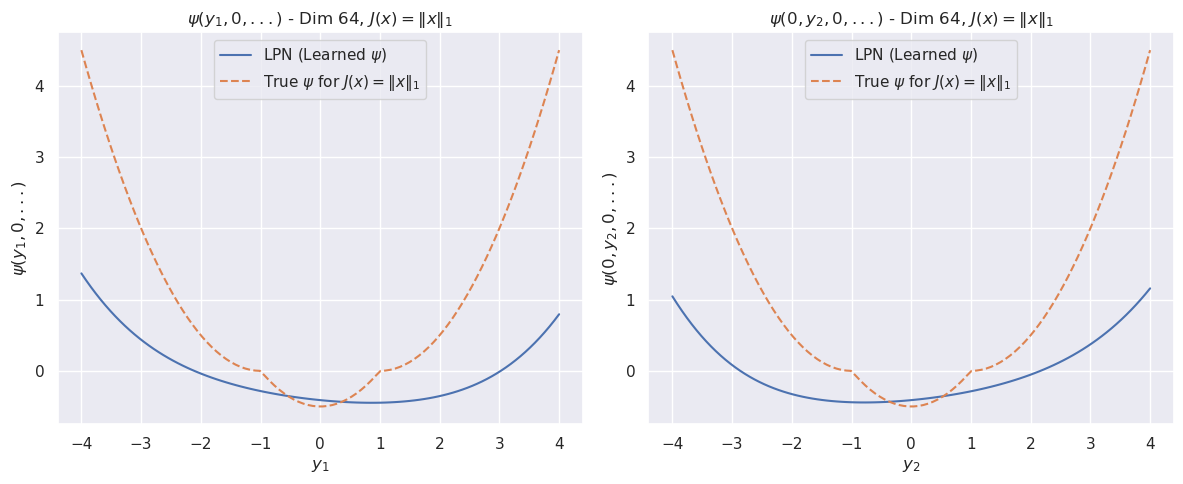

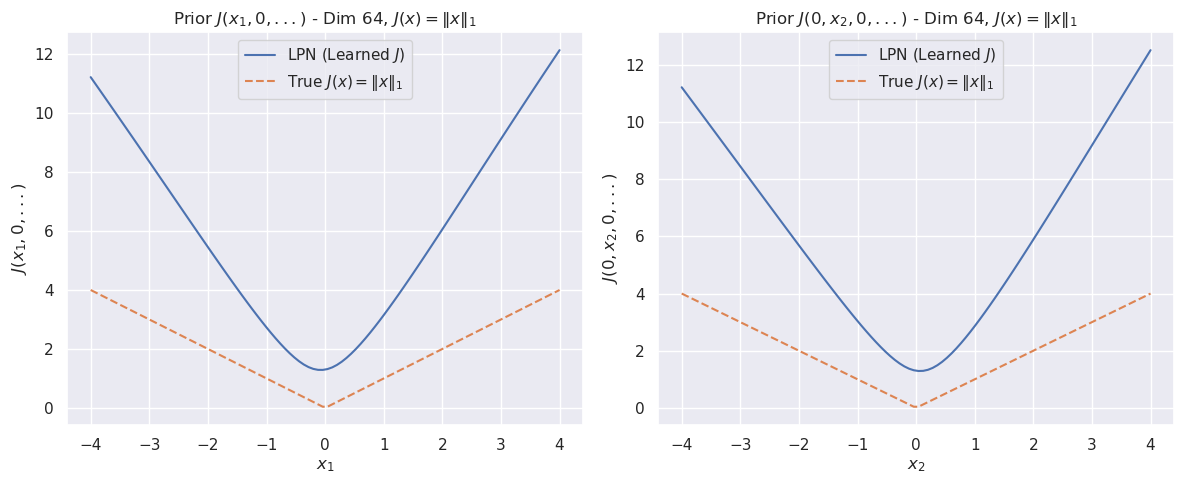

In [8]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

y_k_tensor = lpn_model_quad_l1(x_k_tensor)

inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

tensor([[-0.4111,  0.2946, -1.7372,  ..., -0.2058,  0.7154, -0.1973],
        [-1.5422,  0.0232,  0.2922,  ..., -0.2501,  0.3898,  2.0008],
        [-1.7406, -1.2505,  0.5852,  ...,  1.8706, -0.6294, -2.2833],
        ...,
        [-0.4582,  0.3439,  0.9914,  ...,  0.7696, -1.2341,  1.2853],
        [-1.1150,  1.0495,  0.9279,  ..., -1.6046, -0.3835, -0.3442],
        [ 1.1879, -0.5188, -1.4188,  ...,  1.2450, -1.1240, -1.3805]],
       device='cuda:0')

In [10]:
# --- Step 3: Train 2nd LPN ---
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=1, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 84.42058563232422
iteration 0 loss 3514.597412109375


iteration 500 loss 12.406791687011719


iteration 1000 loss 8.528118133544922


iteration 1500 loss 6.520853042602539


iteration 2000 loss 5.667273998260498


iteration 2500 loss 5.3018293380737305


iteration 3000 loss 5.081735134124756


iteration 3500 loss 4.875089168548584


iteration 4000 loss 4.645314693450928


iteration 4500 loss 4.387811183929443


iteration 5000 loss 4.1064558029174805


iteration 5500 loss 3.8067007064819336


iteration 6000 loss 3.4935476779937744


iteration 6500 loss 3.1714041233062744


iteration 7000 loss 2.8452749252319336


iteration 7500 loss 2.520366668701172


iteration 8000 loss 2.2026991844177246


iteration 8500 loss 1.9018136262893677


iteration 9000 loss 1.6238399744033813


iteration 9500 loss 1.3701367378234863


iteration 10000 loss 1.141579508781433


iteration 10500 loss 0.9437655806541443


iteration 11000 loss 0.8206058144569397


iteration 11500 loss 0.6980502009391785


iteration 12000 loss 0.5888552665710449


iteration 12500 loss 0.5312422513961792


iteration 13000 loss 0.4686395823955536


iteration 13500 loss 0.4021552503108978


iteration 14000 loss 0.35633769631385803


iteration 14500 loss 0.33089253306388855


iteration 15000 loss 0.3017987608909607


iteration 15500 loss 0.2693902254104614


iteration 16000 loss 0.23455891013145447


iteration 16500 loss 0.22087816894054413


iteration 17000 loss 0.2065586894750595


iteration 17500 loss 0.19010686874389648


iteration 18000 loss 0.17170190811157227


iteration 18500 loss 0.1593698263168335


iteration 19000 loss 0.15227165818214417


iteration 19500 loss 0.14388318359851837


iteration 20000 loss 0.13414247334003448


iteration 20500 loss 0.12310696393251419


iteration 21000 loss 0.11766200512647629


iteration 21500 loss 0.11312132328748703


iteration 22000 loss 0.10770703852176666


iteration 22500 loss 0.10134574770927429


iteration 23000 loss 0.09482017904520035


iteration 23500 loss 0.09180651605129242


iteration 24000 loss 0.08834339678287506


iteration 24500 loss 0.08420249074697495


iteration 25000 loss 0.07932154834270477


iteration 25500 loss 0.07650516927242279


iteration 26000 loss 0.07421086728572845


iteration 26500 loss 0.07143262028694153


iteration 27000 loss 0.06810755282640457


iteration 27500 loss 0.0651877149939537


iteration 28000 loss 0.06379565596580505


iteration 28500 loss 0.06218913570046425


iteration 29000 loss 0.06022466719150543


iteration 29500 loss 0.05784774199128151


iteration 30000 loss 0.05549271032214165


iteration 30500 loss 0.05414113774895668


iteration 31000 loss 0.05277508497238159


iteration 31500 loss 0.05110553279519081


iteration 32000 loss 0.04908866435289383


iteration 32500 loss 0.04772118851542473


iteration 33000 loss 0.04678382724523544


iteration 33500 loss 0.045641958713531494


iteration 34000 loss 0.044244423508644104


iteration 34500 loss 0.04255104809999466


iteration 35000 loss 0.041850496083498


iteration 35500 loss 0.04112641513347626


iteration 36000 loss 0.040241289883852005


iteration 36500 loss 0.03915159031748772


iteration 37000 loss 0.03782248869538307


iteration 37500 loss 0.0371708907186985


iteration 38000 loss 0.03663954883813858


iteration 38500 loss 0.035996321588754654


iteration 39000 loss 0.035199616104364395


iteration 39500 loss 0.034219078719615936


iteration 40000 loss 0.033426061272621155


iteration 40500 loss 0.0328984409570694


iteration 41000 loss 0.03242435306310654


iteration 41500 loss 0.031839899718761444


iteration 42000 loss 0.031115975230932236


iteration 42500 loss 0.03022703155875206


iteration 43000 loss 0.029762402176856995


iteration 43500 loss 0.029395025223493576


iteration 44000 loss 0.028969688341021538


iteration 44500 loss 0.028441447764635086


iteration 45000 loss 0.02778702974319458


iteration 45500 loss 0.03676925227046013


iteration 46000 loss 0.026801250874996185


iteration 46500 loss 0.026479778811335564


iteration 47000 loss 0.026088543236255646


iteration 47500 loss 0.025601476430892944


iteration 48000 loss 0.024998435750603676


iteration 48500 loss 0.024555405601859093


iteration 49000 loss 0.02421553246676922


iteration 49500 loss 0.023847386240959167


iteration 50000 loss 0.023391401395201683


iteration 50500 loss 0.02282748930156231


iteration 51000 loss 0.022588836029171944


iteration 51500 loss 0.022336168214678764


iteration 52000 loss 0.022052904590964317


iteration 52500 loss 0.021701928228139877


iteration 53000 loss 0.021265123039484024


iteration 53500 loss 0.020998040214180946


iteration 54000 loss 0.02067316323518753


iteration 54500 loss 0.020437760278582573


iteration 55000 loss 0.02015230432152748


iteration 55500 loss 0.01979714259505272


iteration 56000 loss 0.01935642585158348


iteration 56500 loss 0.019213365390896797


iteration 57000 loss 0.019011642783880234


iteration 57500 loss 0.018784621730446815


iteration 58000 loss 0.018503189086914062


iteration 58500 loss 0.018152501434087753


iteration 59000 loss 0.017915667966008186


iteration 59500 loss 0.017694812268018723


iteration 60000 loss 0.01748233288526535


iteration 60500 loss 0.017219433560967445


iteration 61000 loss 0.016892047598958015


iteration 61500 loss 0.0167322289198637


iteration 62000 loss 0.016537291929125786


iteration 62500 loss 0.016353391110897064


iteration 63000 loss 0.01612752676010132


iteration 63500 loss 0.015846017748117447


iteration 64000 loss 0.015667976811528206


iteration 64500 loss 0.015495214611291885


iteration 65000 loss 0.015343353152275085


iteration 65500 loss 0.01515595056116581


iteration 66000 loss 0.01492114644497633


iteration 66500 loss 0.1458466798067093


iteration 67000 loss 0.01458203699439764


iteration 67500 loss 0.014449703507125378


iteration 68000 loss 0.01430485025048256


iteration 68500 loss 0.014125831425189972


iteration 69000 loss 0.013902048580348492


iteration 69500 loss 0.01380476076155901


iteration 70000 loss 0.01358820591121912


iteration 70500 loss 0.013445641845464706


iteration 71000 loss 0.013274413533508778


iteration 71500 loss 0.01306102890521288


iteration 72000 loss 0.01298378873616457


iteration 72500 loss 0.012818786315619946


iteration 73000 loss 0.01269442867487669


iteration 73500 loss 0.012545885518193245


iteration 74000 loss 0.01236083172261715


iteration 74500 loss 0.012429263442754745


iteration 75000 loss 0.01210072636604309


iteration 75500 loss 0.011982348747551441


iteration 76000 loss 0.011846555396914482


iteration 76500 loss 0.011677983216941357


iteration 77000 loss 0.011698710732161999


iteration 77500 loss 0.011436855420470238


iteration 78000 loss 0.011325015686452389


iteration 78500 loss 0.01119534857571125


iteration 79000 loss 0.011034141294658184


iteration 79500 loss 0.010971610434353352


iteration 80000 loss 0.010836673900485039


iteration 80500 loss 0.010748528875410557


iteration 81000 loss 0.010643591172993183


iteration 81500 loss 0.01051241997629404


iteration 82000 loss 0.01034823339432478


iteration 82500 loss 0.010292763821780682


iteration 83000 loss 0.010197368450462818


iteration 83500 loss 0.010098828934133053


iteration 84000 loss 0.009977179579436779


iteration 84500 loss 0.009825317189097404


iteration 85000 loss 0.009780041873455048


iteration 85500 loss 0.009699970483779907


iteration 86000 loss 0.009617638774216175


iteration 86500 loss 0.009516113437712193


iteration 87000 loss 0.009388724341988564


iteration 87500 loss 0.00939901266247034


iteration 88000 loss 0.009257541969418526


iteration 88500 loss 0.009184327907860279


iteration 89000 loss 0.009105912409722805


iteration 89500 loss 0.00900997407734394


iteration 90000 loss 0.008890558034181595


iteration 90500 loss 0.00889255665242672


iteration 91000 loss 0.008767553605139256


iteration 91500 loss 0.008693902753293514


iteration 92000 loss 0.008611785247921944


iteration 92500 loss 0.008510645478963852


iteration 93000 loss 0.009069744497537613


iteration 93500 loss 0.008365213871002197


iteration 94000 loss 0.00829574279487133


iteration 94500 loss 0.008220546878874302


iteration 95000 loss 0.008127673529088497


iteration 95500 loss 0.37122952938079834


iteration 96000 loss 0.008018439635634422


iteration 96500 loss 0.007947614416480064


iteration 97000 loss 0.007887162268161774


iteration 97500 loss 0.00781620666384697


iteration 98000 loss 0.007728097960352898


iteration 98500 loss 0.008357519283890724


iteration 99000 loss 0.007612861227244139


iteration 99500 loss 0.007555978838354349


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.0074973441660404205


iteration 100500 loss 0.00749003142118454


iteration 101000 loss 0.007480592001229525


iteration 101500 loss 0.007468629162758589


iteration 102000 loss 0.007453461177647114


iteration 102500 loss 0.0074340663850307465


iteration 103000 loss 0.007409265730530024


iteration 103500 loss 0.007377708796411753


iteration 104000 loss 0.007337518036365509


iteration 104500 loss 0.007286437787115574


iteration 105000 loss 0.007221704814583063


iteration 105500 loss 0.007139923516660929


iteration 106000 loss 0.007057892624288797


iteration 106500 loss 0.007026338018476963


iteration 107000 loss 0.006986803840845823


iteration 107500 loss 0.006936526857316494


iteration 108000 loss 0.006872774101793766


iteration 108500 loss 0.006792131811380386


iteration 109000 loss 0.0067253196612000465


iteration 109500 loss 0.006688608322292566


iteration 110000 loss 0.006641989108175039


iteration 110500 loss 0.006582858040928841


iteration 111000 loss 0.0065080574713647366


iteration 111500 loss 0.006443955935537815


iteration 112000 loss 0.006412572227418423


iteration 112500 loss 0.006372853647917509


iteration 113000 loss 0.006322365254163742


iteration 113500 loss 0.006258418317884207


iteration 114000 loss 0.006177886854857206


iteration 114500 loss 0.0061499676667153835


iteration 115000 loss 0.006116597447544336


iteration 115500 loss 0.006074144039303064


iteration 116000 loss 0.006020248867571354


iteration 116500 loss 0.005952051840722561


iteration 117000 loss 0.0059020984917879105


iteration 117500 loss 0.005872692912817001


iteration 118000 loss 0.005835331045091152


iteration 118500 loss 0.005787884816527367


iteration 119000 loss 0.005727758165448904


iteration 119500 loss 0.005667686928063631


iteration 120000 loss 0.005639371462166309


iteration 120500 loss 0.0056038908660411835


iteration 121000 loss 0.005558841396123171


iteration 121500 loss 0.005501837935298681


iteration 122000 loss 0.0054473113268613815


iteration 122500 loss 0.00542569812387228


iteration 123000 loss 0.005398962181061506


iteration 123500 loss 0.005364937242120504


iteration 124000 loss 0.005321714095771313


iteration 124500 loss 0.005266940221190453


iteration 125000 loss 0.005217676982283592


iteration 125500 loss 0.00519221369177103


iteration 126000 loss 0.005160014610737562


iteration 126500 loss 0.005119078792631626


iteration 127000 loss 0.005067205522209406


iteration 127500 loss 0.005020688753575087


iteration 128000 loss 0.004996757488697767


iteration 128500 loss 0.004966487642377615


iteration 129000 loss 0.004928037524223328


iteration 129500 loss 0.004879342392086983


iteration 130000 loss 0.004835500381886959


iteration 130500 loss 0.00481609720736742


iteration 131000 loss 0.00479156756773591


iteration 131500 loss 0.004760330077260733


iteration 132000 loss 0.004720632918179035


iteration 132500 loss 0.004670365713536739


iteration 133000 loss 0.004640420898795128


iteration 133500 loss 0.004617041442543268


iteration 134000 loss 0.004587334580719471


iteration 134500 loss 0.004549577832221985


iteration 135000 loss 0.004501759074628353


iteration 135500 loss 0.004474938847124577


iteration 136000 loss 0.004454189445823431


iteration 136500 loss 0.004427813459187746


iteration 137000 loss 0.004394305869936943


iteration 137500 loss 0.004351811949163675


iteration 138000 loss 0.0043172817677259445


iteration 138500 loss 0.004298976622521877


iteration 139000 loss 0.004275782499462366


iteration 139500 loss 0.004246276803314686


iteration 140000 loss 0.004208788741379976


iteration 140500 loss 0.004168613813817501


iteration 141000 loss 0.004151791334152222


iteration 141500 loss 0.004132629372179508


iteration 142000 loss 0.004108257591724396


iteration 142500 loss 0.004077252000570297


iteration 143000 loss 0.004037939943373203


iteration 143500 loss 0.004010113421827555


iteration 144000 loss 0.00399336963891983


iteration 144500 loss 0.003972186241298914


iteration 145000 loss 0.003945250064134598


iteration 145500 loss 0.003911030478775501


iteration 146000 loss 0.0038750404492020607


iteration 146500 loss 0.0038599893450737


iteration 147000 loss 0.0038420583587139845


iteration 147500 loss 0.003819239791482687


iteration 148000 loss 0.003790193470194936


iteration 148500 loss 0.003753355238586664


iteration 149000 loss 0.003733267541974783


iteration 149500 loss 0.003720040898770094


iteration 150000 loss 0.0037032240070402622


iteration 150500 loss 0.0036817961372435093


iteration 151000 loss 0.0036545463372021914


iteration 151500 loss 0.0036199588794261217


iteration 152000 loss 0.0035978483501821756


iteration 152500 loss 0.003582329023629427


iteration 153000 loss 0.0035626052413135767


iteration 153500 loss 0.0035375449806451797


iteration 154000 loss 0.0035057170316576958


iteration 154500 loss 0.0034822565503418446


iteration 155000 loss 0.0034707083832472563


iteration 155500 loss 0.003456171602010727


iteration 156000 loss 0.0034376352559775114


iteration 156500 loss 0.0034140758216381073


iteration 157000 loss 0.0033841643016785383


iteration 157500 loss 0.0033597820438444614


iteration 158000 loss 0.0033462271094322205


iteration 158500 loss 0.003329116851091385


iteration 159000 loss 0.0033073523081839085


iteration 159500 loss 0.0032796848099678755


iteration 160000 loss 0.0032545002177357674


iteration 160500 loss 0.00324408826418221


iteration 161000 loss 0.003231449518352747


iteration 161500 loss 0.0032153287902474403


iteration 162000 loss 0.0031948122195899487


iteration 162500 loss 0.003168713301420212


iteration 163000 loss 0.0031434649135917425


iteration 163500 loss 0.0031329046469181776


iteration 164000 loss 0.0031198549550026655


iteration 164500 loss 0.0031032285187393427


iteration 165000 loss 0.003082044655457139


iteration 165500 loss 0.0030551718082278967


iteration 166000 loss 0.00303731020539999


iteration 166500 loss 0.003025854006409645


iteration 167000 loss 0.0030113011598587036


iteration 167500 loss 0.002992758760228753


iteration 168000 loss 0.0029691881500184536


iteration 168500 loss 0.0029453453607857227


iteration 169000 loss 0.002935462398454547


iteration 169500 loss 0.002923680003732443


iteration 170000 loss 0.0029086435679346323


iteration 170500 loss 0.002889520488679409


iteration 171000 loss 0.0028652027249336243


iteration 171500 loss 0.0028477839659899473


iteration 172000 loss 0.0028370306827127934


iteration 172500 loss 0.002823395188897848


iteration 173000 loss 0.0028060267213732004


iteration 173500 loss 0.0027839636895805597


iteration 174000 loss 0.0027633681893348694


iteration 174500 loss 0.0027530044317245483


iteration 175000 loss 0.0027403170242905617


iteration 175500 loss 0.002724170684814453


iteration 176000 loss 0.0027036648243665695


iteration 176500 loss 0.0026837012264877558


iteration 177000 loss 0.00267349393106997


iteration 177500 loss 0.0026625534519553185


iteration 178000 loss 0.002648615278303623


iteration 178500 loss 0.0026308761443942785


iteration 179000 loss 0.0026083344127982855


iteration 179500 loss 0.0025969455018639565


iteration 180000 loss 0.0025874883867800236


iteration 180500 loss 0.002575429854914546


iteration 181000 loss 0.002560069551691413


iteration 181500 loss 0.002540546702221036


iteration 182000 loss 0.002523527480661869


iteration 182500 loss 0.002516109962016344


iteration 183000 loss 0.002507158787921071


iteration 183500 loss 0.002495733555406332


iteration 184000 loss 0.002481183037161827


iteration 184500 loss 0.002462677424773574


iteration 185000 loss 0.0024461497087031603


iteration 185500 loss 0.002438422990962863


iteration 186000 loss 0.002429820131510496


iteration 186500 loss 0.0024188642855733633


iteration 187000 loss 0.0024048937484622


iteration 187500 loss 0.0023871352896094322


iteration 188000 loss 0.0023712217807769775


iteration 188500 loss 0.0023642710875719786


iteration 189000 loss 0.002355871256440878


iteration 189500 loss 0.0023451452143490314


iteration 190000 loss 0.002331472234800458


iteration 190500 loss 0.0023140963166952133


iteration 191000 loss 0.0023001828230917454


iteration 191500 loss 0.0022936046589165926


iteration 192000 loss 0.002285825787112117


iteration 192500 loss 0.0022759276907891035


iteration 193000 loss 0.0022632922045886517


iteration 193500 loss 0.0022472399286925793


iteration 194000 loss 0.002232123399153352


iteration 194500 loss 0.0022240951657295227


iteration 195000 loss 0.00221545179374516


iteration 195500 loss 0.0022044104989618063


iteration 196000 loss 0.0021903421729803085


iteration 196500 loss 0.0021725017577409744


iteration 197000 loss 0.0021650868002325296


iteration 197500 loss 0.002157690469175577


iteration 198000 loss 0.002148340456187725


iteration 198500 loss 0.00213641207665205


iteration 199000 loss 0.0021212478168308735


iteration 199500 loss 0.002107934793457389


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.002101083053275943


iteration 200500 loss 0.0021003459114581347


iteration 201000 loss 0.0020993503276258707


iteration 201500 loss 0.0020979742985218763


iteration 202000 loss 0.0020961915142834187


iteration 202500 loss 0.0020939307287335396


iteration 203000 loss 0.0020910368766635656


iteration 203500 loss 0.002087293891236186


iteration 204000 loss 0.0020824840757995844


iteration 204500 loss 0.0020763978827744722


iteration 205000 loss 0.0020686492789536715


iteration 205500 loss 0.0020587590988725424


iteration 206000 loss 0.0020462307147681713


iteration 206500 loss 0.0020304261706769466


iteration 207000 loss 0.0020194530952721834


iteration 207500 loss 0.0020077303051948547


iteration 208000 loss 0.001992936944589019


iteration 208500 loss 0.0019821394234895706


iteration 209000 loss 0.001972984755411744


iteration 209500 loss 0.001961369765922427


iteration 210000 loss 0.0019466998055577278


iteration 210500 loss 0.0019358923891559243


iteration 211000 loss 0.0019251297926530242


iteration 211500 loss 0.0019115222385153174


iteration 212000 loss 0.0019003890920430422


iteration 212500 loss 0.0018926160410046577


iteration 213000 loss 0.0018826950108632445


iteration 213500 loss 0.0018701455555856228


iteration 214000 loss 0.0018576763104647398


iteration 214500 loss 0.0018506350461393595


iteration 215000 loss 0.0018416589591652155


iteration 215500 loss 0.0018302734242752194


iteration 216000 loss 0.0018247603438794613


iteration 216500 loss 0.0018084578914567828


iteration 217000 loss 0.0017988559557124972


iteration 217500 loss 0.0017867038259282708


iteration 218000 loss 0.001775793032720685


iteration 218500 loss 0.0017689494416117668


iteration 219000 loss 0.0017602351726964116


iteration 219500 loss 0.0017491969047114253


iteration 220000 loss 0.0017361274221912026


iteration 220500 loss 0.0017298253951594234


iteration 221000 loss 0.0017218196298927069


iteration 221500 loss 0.001711654243990779


iteration 222000 loss 0.0016988021088764071


iteration 222500 loss 0.0016920070629566908


iteration 223000 loss 0.0016857709269970655


iteration 223500 loss 0.0016778534045442939


iteration 224000 loss 0.0016677970997989178


iteration 224500 loss 0.0016903214855119586


iteration 225000 loss 0.001649546204134822


iteration 225500 loss 0.0016423278721049428


iteration 226000 loss 0.0016331435181200504


iteration 226500 loss 0.0016215213108807802


iteration 227000 loss 0.0016139076324179769


iteration 227500 loss 0.001607568934559822


iteration 228000 loss 0.0015995046123862267


iteration 228500 loss 0.001589279156178236


iteration 229000 loss 0.0015793173806741834


iteration 229500 loss 0.0015730330487713218


iteration 230000 loss 0.0015650445129722357


iteration 230500 loss 0.0015549155650660396


iteration 231000 loss 0.0015456360997632146


iteration 231500 loss 0.0015387574676424265


iteration 232000 loss 0.001529988832771778


iteration 232500 loss 0.0015189213445410132


iteration 233000 loss 0.001513041672296822


iteration 233500 loss 0.0015060736332088709


iteration 234000 loss 0.0014972144272178411


iteration 234500 loss 0.0014869491569697857


iteration 235000 loss 0.001482081599533558


iteration 235500 loss 0.0014758910983800888


iteration 236000 loss 0.0014680067542940378


iteration 236500 loss 0.0014580333372578025


iteration 237000 loss 0.0014518264215439558


iteration 237500 loss 0.0014463906409218907


iteration 238000 loss 0.0014394887257367373


iteration 238500 loss 0.0014307156670838594


iteration 239000 loss 0.0014220268931239843


iteration 239500 loss 0.0014165256870910525


iteration 240000 loss 0.001409557182341814


iteration 240500 loss 0.0014006979763507843


iteration 241000 loss 0.0013930248096585274


iteration 241500 loss 0.001387601951137185


iteration 242000 loss 0.0013807107461616397


iteration 242500 loss 0.0013719607377424836


iteration 243000 loss 0.0013651605695486069


iteration 243500 loss 0.0013606231659650803


iteration 244000 loss 0.0013548457063734531


iteration 244500 loss 0.0013474930310621858


iteration 245000 loss 0.0013381876051425934


iteration 245500 loss 0.0013335836119949818


iteration 246000 loss 0.0013283321168273687


iteration 246500 loss 0.0013216625666245818


iteration 247000 loss 0.0013131994055584073


iteration 247500 loss 0.0013074333546683192


iteration 248000 loss 0.0013031043345108628


iteration 248500 loss 0.0012975733261555433


iteration 249000 loss 0.0012905524345114827


iteration 249500 loss 0.001282330835238099


iteration 250000 loss 0.0012769759632647038


iteration 250500 loss 0.0012711024610325694


iteration 251000 loss 0.001263631391339004


iteration 251500 loss 0.0012563953641802073


iteration 252000 loss 0.0012518818257376552


iteration 252500 loss 0.0012461348669603467


iteration 253000 loss 0.0012388210743665695


iteration 253500 loss 0.001231906353496015


iteration 254000 loss 0.0012277407804504037


iteration 254500 loss 0.0012224253732711077


iteration 255000 loss 0.001215672236867249


iteration 255500 loss 0.0012079793959856033


iteration 256000 loss 0.0012041990412399173


iteration 256500 loss 0.0011993844527751207


iteration 257000 loss 0.0011932695051655173


iteration 257500 loss 0.0011855021584779024


iteration 258000 loss 0.0011809037532657385


iteration 258500 loss 0.0011760187335312366


iteration 259000 loss 0.001169820548966527


iteration 259500 loss 0.0011746241943910718


iteration 260000 loss 0.001158500206656754


iteration 260500 loss 0.0011540156556293368


iteration 261000 loss 0.0011483337730169296


iteration 261500 loss 0.0011411004234105349


iteration 262000 loss 0.0011364722158759832


iteration 262500 loss 0.0011321239871904254


iteration 263000 loss 0.0011266089277341962


iteration 263500 loss 0.0011195895494893193


iteration 264000 loss 0.0011151396902278066


iteration 264500 loss 0.001111042220145464


iteration 265000 loss 0.001105824951082468


iteration 265500 loss 0.0010991856688633561


iteration 266000 loss 0.0010945983231067657


iteration 266500 loss 0.001091274432837963


iteration 267000 loss 0.001087045413441956


iteration 267500 loss 0.001081678201444447


iteration 268000 loss 0.0010748616186901927


iteration 268500 loss 0.001071493374183774


iteration 269000 loss 0.0010681068524718285


iteration 269500 loss 0.0010637996019795537


iteration 270000 loss 0.001058337977156043


iteration 270500 loss 0.0010524604003876448


iteration 271000 loss 0.0010486075188964605


iteration 271500 loss 0.0010447915410622954


iteration 272000 loss 0.001039923052303493


iteration 272500 loss 0.0010337437270209193


iteration 273000 loss 0.0010296367108821869


iteration 273500 loss 0.0010266946628689766


iteration 274000 loss 0.0010229793842881918


iteration 274500 loss 0.001018231501802802


iteration 275000 loss 0.0010122114326804876


iteration 275500 loss 0.00100826530251652


iteration 276000 loss 0.0010054003214463592


iteration 276500 loss 0.001001784228719771


iteration 277000 loss 0.000997171038761735


iteration 277500 loss 0.0009913252433761954


iteration 278000 loss 0.0009870637441053987


iteration 278500 loss 0.0009834090014919639


iteration 279000 loss 0.0009787542512640357


iteration 279500 loss 0.0009728409349918365


iteration 280000 loss 0.0009693008032627404


iteration 280500 loss 0.0009660745272412896


iteration 281000 loss 0.0009619707125239074


iteration 281500 loss 0.0009567575179971755


iteration 282000 loss 0.0009518701117485762


iteration 282500 loss 0.0009486352792009711


iteration 283000 loss 0.0009445188334211707


iteration 283500 loss 0.0009392915526404977


iteration 284000 loss 0.0009351289481855929


iteration 284500 loss 0.0009326425497420132


iteration 285000 loss 0.0009294740157201886


iteration 285500 loss 0.0009254474425688386


iteration 286000 loss 0.000920336227864027


iteration 286500 loss 0.0009160460904240608


iteration 287000 loss 0.0009128621895797551


iteration 287500 loss 0.0009088102960959077


iteration 288000 loss 0.0009036646806634963


iteration 288500 loss 0.0009001438156701624


iteration 289000 loss 0.0008975578821264207


iteration 289500 loss 0.0008942832937464118


iteration 290000 loss 0.000890115334186703


iteration 290500 loss 0.0008848356083035469


iteration 291000 loss 0.0008822380914352834


iteration 291500 loss 0.0008796296897344291


iteration 292000 loss 0.0008763449732214212


iteration 292500 loss 0.000872151751536876


iteration 293000 loss 0.0008779643685556948


iteration 293500 loss 0.0008648993098177016


iteration 294000 loss 0.0008624036563560367


iteration 294500 loss 0.0008592498488724232


iteration 295000 loss 0.0008552348590455949


iteration 295500 loss 0.0008501476258970797


iteration 296000 loss 0.0008475743816234171


iteration 296500 loss 0.000844708236400038


iteration 297000 loss 0.0008410676964558661


iteration 297500 loss 0.0008364511304534972


iteration 298000 loss 0.00083304347936064


iteration 298500 loss 0.0008303861250169575


iteration 299000 loss 0.0008270289981737733


iteration 299500 loss 0.0008227566722780466


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.0008189143263734877


iteration 300500 loss 0.0008187482599169016


iteration 301000 loss 0.0008185283513739705


iteration 301500 loss 0.0008182245073840022


iteration 302000 loss 0.000817813677713275


iteration 302500 loss 0.0008172633242793381


iteration 303000 loss 0.0008165071485564113


iteration 303500 loss 0.0008155382238328457


iteration 304000 loss 0.0008143370505422354


iteration 304500 loss 0.0008128308109007776


iteration 305000 loss 0.0008109639747999609


iteration 305500 loss 0.0008086877642199397


iteration 306000 loss 0.0008059896063059568


iteration 306500 loss 0.0008028444135561585


iteration 307000 loss 0.0007992470636963844


iteration 307500 loss 0.0007955967448651791


iteration 308000 loss 0.000791991304140538


iteration 308500 loss 0.0007884167716838419


iteration 309000 loss 0.0007848719251342118


iteration 309500 loss 0.0007813592674210668


iteration 310000 loss 0.0007778754807077348


iteration 310500 loss 0.0007744091562926769


iteration 311000 loss 0.0007709768833592534


iteration 311500 loss 0.0007675750530324876


iteration 312000 loss 0.0007641830015927553


iteration 312500 loss 0.0007608198211528361


iteration 313000 loss 0.0007574754417873919


iteration 313500 loss 0.0007541659288108349


iteration 314000 loss 0.0007508692797273397


iteration 314500 loss 0.0007475946913473308


iteration 315000 loss 0.0007443478680215776


iteration 315500 loss 0.000741112045943737


iteration 316000 loss 0.0007379018352366984


iteration 316500 loss 0.0007346992497332394


iteration 317000 loss 0.0007315194816328585


iteration 317500 loss 0.0007283666636794806


iteration 318000 loss 0.0007252260111272335


iteration 318500 loss 0.0007221022970043123


iteration 319000 loss 0.0007189935422502458


iteration 319500 loss 0.0007159003289416432


iteration 320000 loss 0.0007128164288587868


iteration 320500 loss 0.0007097539491951466


iteration 321000 loss 0.0007067116675898433


iteration 321500 loss 0.0007036775932647288


iteration 322000 loss 0.0007006636587902904


iteration 322500 loss 0.0006976692820899189


iteration 323000 loss 0.0006946876528672874


iteration 323500 loss 0.0006917176069691777


iteration 324000 loss 0.0006887633353471756


iteration 324500 loss 0.0006858291453681886


iteration 325000 loss 0.0006829011836089194


iteration 325500 loss 0.0006799956900067627


iteration 326000 loss 0.0006771083571948111


iteration 326500 loss 0.0006742285331711173


iteration 327000 loss 0.000671368557959795


iteration 327500 loss 0.0006685183616355062


iteration 328000 loss 0.0006656819023191929


iteration 328500 loss 0.0006628661067225039


iteration 329000 loss 0.0006600581691600382


iteration 329500 loss 0.0006572655402123928


iteration 330000 loss 0.0006544867064803839


iteration 330500 loss 0.0006517216097563505


iteration 331000 loss 0.0006489680963568389


iteration 331500 loss 0.0006462297169491649


iteration 332000 loss 0.0006435062387026846


iteration 332500 loss 0.0006407925393432379


iteration 333000 loss 0.0006380870472639799


iteration 333500 loss 0.000635399657767266


iteration 334000 loss 0.000632723153103143


iteration 334500 loss 0.0006300585810095072


iteration 335000 loss 0.0006274059996940196


iteration 335500 loss 0.0006247672135941684


iteration 336000 loss 0.0006221418734639883


iteration 336500 loss 0.0006195218884386122


iteration 337000 loss 0.0006169191328808665


iteration 337500 loss 0.00061432970687747


iteration 338000 loss 0.0006117525044828653


iteration 338500 loss 0.0006091829854995012


iteration 339000 loss 0.0006066287169232965


iteration 339500 loss 0.0006040862645022571


iteration 340000 loss 0.0006015552207827568


iteration 340500 loss 0.0005990364588797092


iteration 341000 loss 0.0005965305026620626


iteration 341500 loss 0.0005940328701399267


iteration 342000 loss 0.0005915503134019673


iteration 342500 loss 0.000589078466873616


iteration 343000 loss 0.0005866173305548728


iteration 343500 loss 0.0005841656238771975


iteration 344000 loss 0.0005817288183607161


iteration 344500 loss 0.0005793010350316763


iteration 345000 loss 0.0005768818082287908


iteration 345500 loss 0.0005744771915487945


iteration 346000 loss 0.0005720792105421424


iteration 346500 loss 0.0005696964799426496


iteration 347000 loss 0.0005673213163390756


iteration 347500 loss 0.0005649583763442934


iteration 348000 loss 0.0005626032943837345


iteration 348500 loss 0.0005602602614089847


iteration 349000 loss 0.0005579243297688663


iteration 349500 loss 0.0005556052201427519


iteration 350000 loss 0.0005532874492928386


iteration 350500 loss 0.0005509865586645901


iteration 351000 loss 0.0005486932350322604


iteration 351500 loss 0.0005464089335873723


iteration 352000 loss 0.0005441335961222649


iteration 352500 loss 0.0005418685032054782


iteration 353000 loss 0.000539617205504328


iteration 353500 loss 0.0005373685853555799


iteration 354000 loss 0.0005351309664547443


iteration 354500 loss 0.0005329048726707697


iteration 355000 loss 0.0005306873936206102


iteration 355500 loss 0.0005284806829877198


iteration 356000 loss 0.000526284973602742


iteration 356500 loss 0.0005240977043285966


iteration 357000 loss 0.0005219154991209507


iteration 357500 loss 0.0005197453428991139


iteration 358000 loss 0.000517590728122741


iteration 358500 loss 0.0005154347163625062


iteration 359000 loss 0.00051329773850739


iteration 359500 loss 0.0005111641949042678


iteration 360000 loss 0.0005090365884825587


iteration 360500 loss 0.0005069130565971136


iteration 361000 loss 0.0005048069288022816


iteration 361500 loss 0.0005027090082876384


iteration 362000 loss 0.0005006178980693221


iteration 362500 loss 0.0004985362756997347


iteration 363000 loss 0.0004964635008946061


iteration 363500 loss 0.0004944007960148156


iteration 364000 loss 0.000492348219268024


iteration 364500 loss 0.0004902997170574963


iteration 365000 loss 0.00048826035344973207


iteration 365500 loss 0.00048623388283886015


iteration 366000 loss 0.0004842134367208928


iteration 366500 loss 0.00048220064491033554


iteration 367000 loss 0.0004801996983587742


iteration 367500 loss 0.0004782063770107925


iteration 368000 loss 0.0004762223979923874


iteration 368500 loss 0.0004742440942209214


iteration 369000 loss 0.00047227638424374163


iteration 369500 loss 0.0004703095182776451


iteration 370000 loss 0.00046836130786687136


iteration 370500 loss 0.0004664162115659565


iteration 371000 loss 0.00046448310604318976


iteration 371500 loss 0.00046255497727543116


iteration 372000 loss 0.00046063249465078115


iteration 372500 loss 0.00045872238115407526


iteration 373000 loss 0.0004568177100736648


iteration 373500 loss 0.000454927037935704


iteration 374000 loss 0.00045303752995096147


iteration 374500 loss 0.0004511712468229234


iteration 375000 loss 0.0004493017040658742


iteration 375500 loss 0.0004474372835829854


iteration 376000 loss 0.00044558566878549755


iteration 376500 loss 0.0004437419702298939


iteration 377000 loss 0.00044190147309564054


iteration 377500 loss 0.0004400692705530673


iteration 378000 loss 0.0004382466140668839


iteration 378500 loss 0.0004364306223578751


iteration 379000 loss 0.0004346249043010175


iteration 379500 loss 0.000432822504080832


iteration 380000 loss 0.0004310324147809297


iteration 380500 loss 0.000429244595579803


iteration 381000 loss 0.0004274678649380803


iteration 381500 loss 0.0004256980901118368


iteration 382000 loss 0.0004239361733198166


iteration 382500 loss 0.0004221878480166197


iteration 383000 loss 0.0004204371361993253


iteration 383500 loss 0.0004187012673355639


iteration 384000 loss 0.00041696985135786235


iteration 384500 loss 0.0004152409383095801


iteration 385000 loss 0.00041353204869665205


iteration 385500 loss 0.00041181695996783674


iteration 386000 loss 0.00041011476423591375


iteration 386500 loss 0.00040841897134669125


iteration 387000 loss 0.00040672958130016923


iteration 387500 loss 0.00040504682692699134


iteration 388000 loss 0.0004033766745124012


iteration 388500 loss 0.00040170722058974206


iteration 389000 loss 0.0004000471963081509


iteration 389500 loss 0.00039839217788539827


iteration 390000 loss 0.000396742980228737


iteration 390500 loss 0.0003951035032514483


iteration 391000 loss 0.0003934703709091991


iteration 391500 loss 0.0003918418660759926


iteration 392000 loss 0.0003902241587638855


iteration 392500 loss 0.00038860974018462


iteration 393000 loss 0.0003870043728966266


iteration 393500 loss 0.0003854020033031702


iteration 394000 loss 0.0003838084521703422


iteration 394500 loss 0.00038222060538828373


iteration 395000 loss 0.0003806420718319714


iteration 395500 loss 0.0003790702612604946


iteration 396000 loss 0.0003774989163503051


iteration 396500 loss 0.0003759373212233186


iteration 397000 loss 0.00037438521394506097


iteration 397500 loss 0.00037283654091879725


iteration 398000 loss 0.00037129942211322486


iteration 398500 loss 0.0003697614010889083


iteration 399000 loss 0.0003682366223074496


iteration 399500 loss 0.00036671123234555125


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.0003651961451396346


iteration 400500 loss 0.00036506212200038135


iteration 401000 loss 0.000364907318726182


iteration 401500 loss 0.0003647261473815888


iteration 402000 loss 0.00036451706546358764


iteration 402500 loss 0.0003642818774096668


iteration 403000 loss 0.0003640318172983825


iteration 403500 loss 0.00036375923082232475


iteration 404000 loss 0.00036347645800560713


iteration 404500 loss 0.0003631731669884175


iteration 405000 loss 0.00036286687827669084


iteration 405500 loss 0.00036255226586945355


iteration 406000 loss 0.00036224222276359797


iteration 406500 loss 0.0003619347990024835


iteration 407000 loss 0.00036162929609417915


iteration 407500 loss 0.00036132530658505857


iteration 408000 loss 0.00036102341255173087


iteration 408500 loss 0.00036072710645385087


iteration 409000 loss 0.00036042480496689677


iteration 409500 loss 0.000360128324246034


iteration 410000 loss 0.00035983556881546974


iteration 410500 loss 0.00035953946644440293


iteration 411000 loss 0.00035924609983339906


iteration 411500 loss 0.00035895861219614744


iteration 412000 loss 0.000358667311957106


iteration 412500 loss 0.00035837534232996404


iteration 413000 loss 0.00035808724351227283


iteration 413500 loss 0.000357798213372007


iteration 414000 loss 0.0003575119480956346


iteration 414500 loss 0.0003572288842406124


iteration 415000 loss 0.00035694625694304705


iteration 415500 loss 0.00035666165058501065


iteration 416000 loss 0.0003563810314517468


iteration 416500 loss 0.0003560998884495348


iteration 417000 loss 0.00035581746487878263


iteration 417500 loss 0.0003555415023583919


iteration 418000 loss 0.0003552702546585351


iteration 418500 loss 0.0003549999091774225


iteration 419000 loss 0.00035472973831929266


iteration 419500 loss 0.00035446096444502473


iteration 420000 loss 0.0003541956248227507


iteration 420500 loss 0.0003539333993103355


iteration 421000 loss 0.00035366349038667977


iteration 421500 loss 0.00035340123577043414


iteration 422000 loss 0.0003531346737872809


iteration 422500 loss 0.00035287445643916726


iteration 423000 loss 0.00035261057200841606


iteration 423500 loss 0.00035235131508670747


iteration 424000 loss 0.00035208725603297353


iteration 424500 loss 0.00035183026921004057


iteration 425000 loss 0.00035156801459379494


iteration 425500 loss 0.00035130998003296554


iteration 426000 loss 0.0003510496171656996


iteration 426500 loss 0.00035079006920568645


iteration 427000 loss 0.0003505329950712621


iteration 427500 loss 0.00035027804551646113


iteration 428000 loss 0.00035002283402718604


iteration 428500 loss 0.0003497650322970003


iteration 429000 loss 0.0003495084529276937


iteration 429500 loss 0.00034925484214909375


iteration 430000 loss 0.00034900096943601966


iteration 430500 loss 0.0003487462818156928


iteration 431000 loss 0.00034849310759454966


iteration 431500 loss 0.00034824214526452124


iteration 432000 loss 0.0003479899314697832


iteration 432500 loss 0.0003477356513030827


iteration 433000 loss 0.00034748544567264616


iteration 433500 loss 0.0003472327662166208


iteration 434000 loss 0.0003469863149803132


iteration 434500 loss 0.00034673631307668984


iteration 435000 loss 0.0003464842739049345


iteration 435500 loss 0.00034623712417669594


iteration 436000 loss 0.00034598997444845736


iteration 436500 loss 0.0003457418642938137


iteration 437000 loss 0.00034549087285995483


iteration 437500 loss 0.0003452484670560807


iteration 438000 loss 0.00034500067704357207


iteration 438500 loss 0.0003447544004302472


iteration 439000 loss 0.0003445085312705487


iteration 439500 loss 0.0003442644083406776


iteration 440000 loss 0.000344019295880571


iteration 440500 loss 0.00034377395058982074


iteration 441000 loss 0.00034353116643615067


iteration 441500 loss 0.0003432868979871273


iteration 442000 loss 0.0003430442593526095


iteration 442500 loss 0.0003428028430789709


iteration 443000 loss 0.0003425588074605912


iteration 443500 loss 0.0003423175367061049


iteration 444000 loss 0.0003420772554818541


iteration 444500 loss 0.00034183557727374136


iteration 445000 loss 0.00034159779897890985


iteration 445500 loss 0.0003413539379835129


iteration 446000 loss 0.0003411142388358712


iteration 446500 loss 0.0003408748598303646


iteration 447000 loss 0.0003406385367270559


iteration 447500 loss 0.0003403982555028051


iteration 448000 loss 0.0003401592548470944


iteration 448500 loss 0.0003399199340492487


iteration 449000 loss 0.00033968384377658367


iteration 449500 loss 0.00033944996539503336


iteration 450000 loss 0.0003392102662473917


iteration 450500 loss 0.000338974961778149


iteration 451000 loss 0.0003387379692867398


iteration 451500 loss 0.00033850231557153165


iteration 452000 loss 0.0003382678551133722


iteration 452500 loss 0.0003380317648407072


iteration 453000 loss 0.0003377984103281051


iteration 453500 loss 0.00033756508491933346


iteration 454000 loss 0.00033733053714968264


iteration 454500 loss 0.0003370986960362643


iteration 455000 loss 0.00033686423557810485


iteration 455500 loss 0.000336630386300385


iteration 456000 loss 0.0003363977011758834


iteration 456500 loss 0.0003361645503900945


iteration 457000 loss 0.00033592976978980005


iteration 457500 loss 0.00033570246887393296


iteration 458000 loss 0.0003354704240337014


iteration 458500 loss 0.00033523872843943536


iteration 459000 loss 0.0003350079932715744


iteration 459500 loss 0.0003347769670654088


iteration 460000 loss 0.00033454757067374885


iteration 460500 loss 0.0003343160205986351


iteration 461000 loss 0.00033408854505978525


iteration 461500 loss 0.0003338598762638867


iteration 462000 loss 0.0003336324589326978


iteration 462500 loss 0.0003334010543767363


iteration 463000 loss 0.00033317311317659914


iteration 463500 loss 0.0003329469764139503


iteration 464000 loss 0.0003327197046019137


iteration 464500 loss 0.0003324927238281816


iteration 465000 loss 0.0003322650445625186


iteration 465500 loss 0.00033203946077264845


iteration 466000 loss 0.0003318121307529509


iteration 466500 loss 0.00033158730366267264


iteration 467000 loss 0.0003313607594463974


iteration 467500 loss 0.0003311332256998867


iteration 468000 loss 0.0003309080202598125


iteration 468500 loss 0.000330681970808655


iteration 469000 loss 0.00033046037424355745


iteration 469500 loss 0.00033023394644260406


iteration 470000 loss 0.00033001098199747503


iteration 470500 loss 0.0003297861840110272


iteration 471000 loss 0.0003295617934782058


iteration 471500 loss 0.0003293374029453844


iteration 472000 loss 0.00032911618473008275


iteration 472500 loss 0.0003288937150500715


iteration 473000 loss 0.00032867249683476985


iteration 473500 loss 0.00032844810630194843


iteration 474000 loss 0.00032822758657857776


iteration 474500 loss 0.00032800331246107817


iteration 475000 loss 0.000327782443491742


iteration 475500 loss 0.00032756439759396017


iteration 476000 loss 0.000327344227116555


iteration 476500 loss 0.00032712117535993457


iteration 477000 loss 0.00032690318766981363


iteration 477500 loss 0.0003266805724706501


iteration 478000 loss 0.00032646176987327635


iteration 478500 loss 0.0003262416284997016


iteration 479000 loss 0.0003260220109950751


iteration 479500 loss 0.0003258050710428506


iteration 480000 loss 0.00032558542443439364


iteration 480500 loss 0.0003253661561757326


iteration 481000 loss 0.0003251495072618127


iteration 481500 loss 0.00032493146136403084


iteration 482000 loss 0.00032471134909428656


iteration 482500 loss 0.00032449577702209353


iteration 483000 loss 0.00032427767291665077


iteration 483500 loss 0.0003240624791942537


iteration 484000 loss 0.0003238452482037246


iteration 484500 loss 0.0003236271732021123


iteration 485000 loss 0.00032341378391720355


iteration 485500 loss 0.0003231947193853557


iteration 486000 loss 0.00032298057340085506


iteration 486500 loss 0.0003227652341593057


iteration 487000 loss 0.00032254928373731673


iteration 487500 loss 0.000322334177326411


iteration 488000 loss 0.00032212017686106265


iteration 488500 loss 0.0003219078353140503


iteration 489000 loss 0.0003216934856027365


iteration 489500 loss 0.0003214803582523018


iteration 490000 loss 0.00032126635778695345


iteration 490500 loss 0.00032105090213008225


iteration 491000 loss 0.00032083899714052677


iteration 491500 loss 0.00032062461832538247


iteration 492000 loss 0.00032041309168562293


iteration 492500 loss 0.0003202000225428492


iteration 493000 loss 0.00031998768099583685


iteration 493500 loss 0.0003197749028913677


iteration 494000 loss 0.0003195621829945594


iteration 494500 loss 0.0003193521988578141


iteration 495000 loss 0.0003191395662724972


iteration 495500 loss 0.0003189301351085305


iteration 496000 loss 0.00031871633836999536


iteration 496500 loss 0.00031850652885623276


iteration 497000 loss 0.00031829660292714834


iteration 497500 loss 0.00031808516359888017


iteration 498000 loss 0.0003178764309268445


iteration 498500 loss 0.0003176644677296281


iteration 499000 loss 0.0003174565208610147


iteration 499500 loss 0.0003172465949319303


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


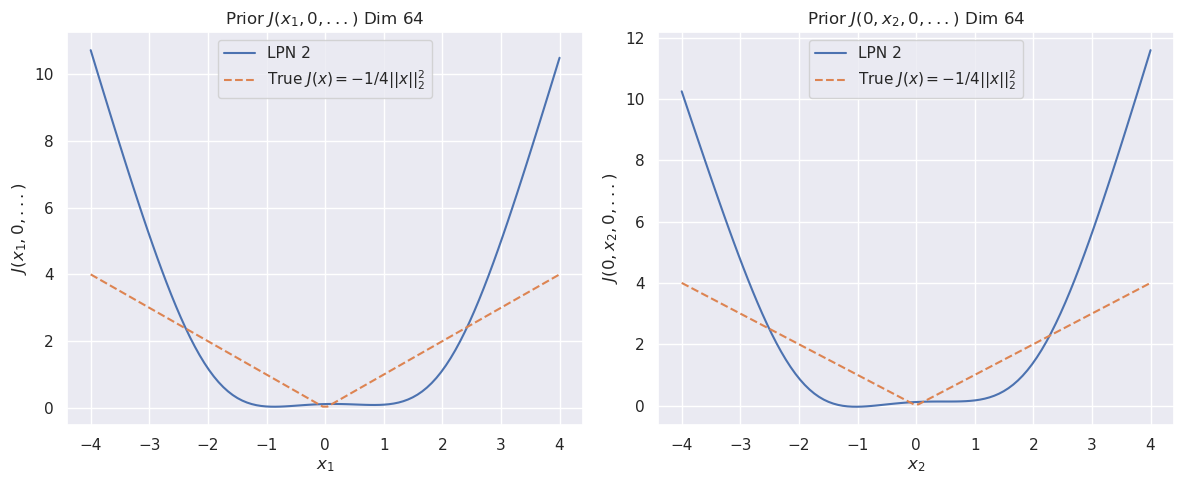

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)